# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

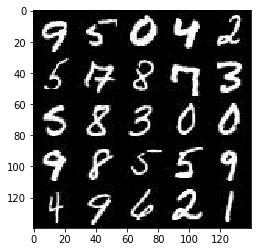

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import numpy as np
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')
pyplot.show()

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

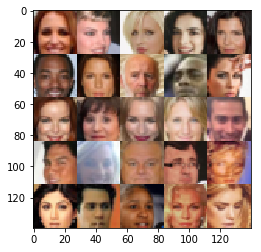

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))
pyplot.show()

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels),
                                name='input_real')
    input_z = tf.placeholder(tf.float32, (None,z_dim),
                            name='input_z')
    learning_rate = tf.placeholder(tf.float32,
                                   name='learning_rate')

    return input_real,input_z,learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha =0.1
        # Input layer is 28x28x3 ### don't use batch norm on first input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1 ,rate = 0.2)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate = 0.2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.layers.dropout(relu4, rate = 0.2)
        # 7x7x512
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.3)
        out = tf.sigmoid(logits)

    return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.1
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        
#         x1 = tf.layers.conv2d_transpose(x1, 512, 2, strides=1, padding='same',
#                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
#         x1 = tf.layers.batch_normalization(x1, training=is_train)
#         x1 = tf.maximum(alpha * x1, x1)
#         x1 = tf.layers.dropout(x1, rate = 0.5)
        # 7x7x512 now
        
        x1 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
#         x1 = tf.layers.dropout(x1, rate = 0.2)
        # 14x14x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         x2 = tf.layers.dropout(x2, rate = 0.2)
        # 28x28x128 now
        
        x2 = tf.layers.conv2d_transpose(x2, 64, 4, strides=1, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         x2 = tf.layers.dropout(x2, rate = 0.2)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 4, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
#         logits = tf.layers.dropout(logits, rate=0.3)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})
    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.array(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    input_image,input_z,_ = model_inputs(image_width=data_shape[1],
                                          image_height=data_shape[2],
                                          image_channels=data_shape[3],
                                          z_dim=z_dim)
    
    d_loss, g_loss = model_loss(input_image, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
#                 Try without the below line
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_train_opt, feed_dict={input_image: batch_images,
                                                     input_z: batch_z})
                sess.run(4*[g_train_opt], feed_dict={input_z: batch_z})
                
                if steps % 100 == 0:
                    # At the end of every 500 steps, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_image: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [35]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

Epoch 1/2... Discriminator Loss: 2.5779... Generator Loss: 0.2130


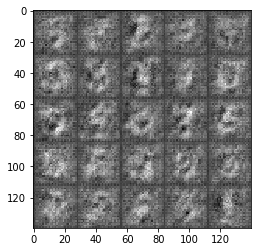

Epoch 1/2... Discriminator Loss: 2.0682... Generator Loss: 0.2344


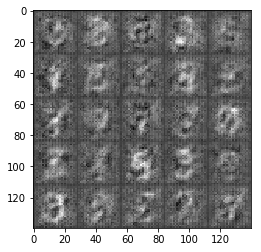

Epoch 1/2... Discriminator Loss: 1.8323... Generator Loss: 0.3131


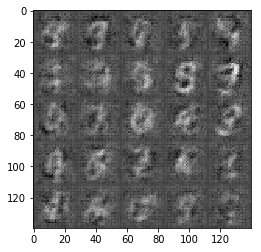

Epoch 1/2... Discriminator Loss: 1.7172... Generator Loss: 0.3493


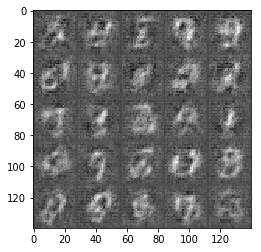

Epoch 1/2... Discriminator Loss: 1.7473... Generator Loss: 0.3237


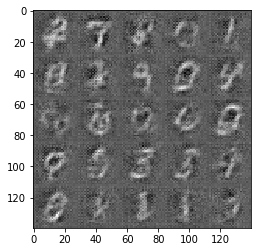

Epoch 1/2... Discriminator Loss: 1.8261... Generator Loss: 0.3031


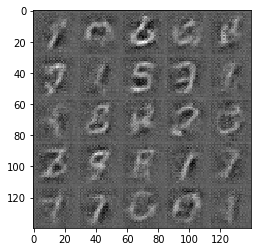

Epoch 1/2... Discriminator Loss: 1.6472... Generator Loss: 0.3895


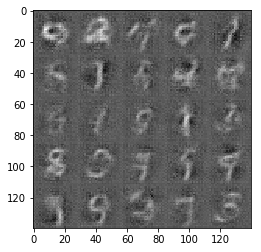

Epoch 1/2... Discriminator Loss: 1.6639... Generator Loss: 0.3739


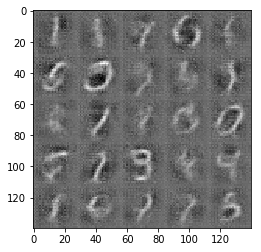

Epoch 1/2... Discriminator Loss: 1.6127... Generator Loss: 0.4490


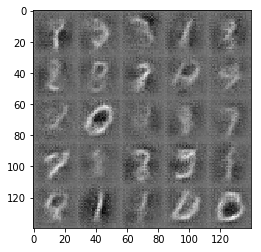

Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.8861


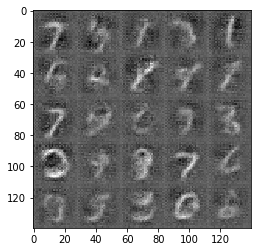

Epoch 1/2... Discriminator Loss: 1.7148... Generator Loss: 0.3685


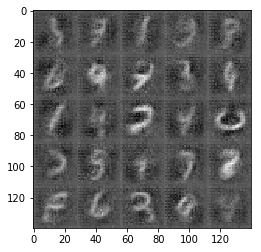

Epoch 1/2... Discriminator Loss: 1.6139... Generator Loss: 0.4120


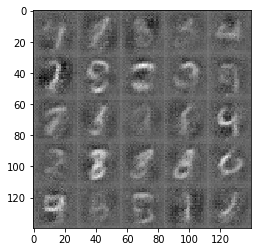

Epoch 1/2... Discriminator Loss: 1.5351... Generator Loss: 0.5159


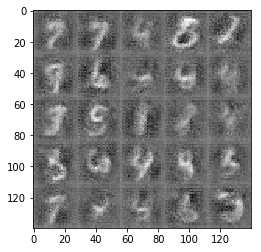

Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 0.4828


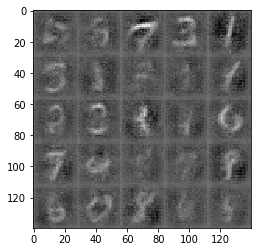

Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.4319


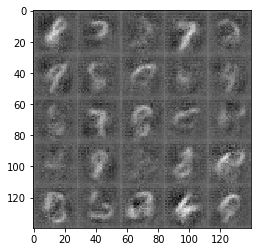

Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.7678


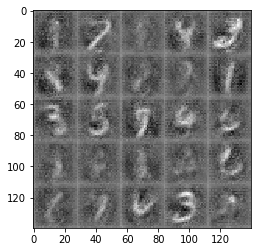

Epoch 1/2... Discriminator Loss: 1.6560... Generator Loss: 1.0885


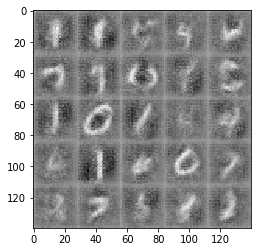

Epoch 1/2... Discriminator Loss: 1.6510... Generator Loss: 1.0284


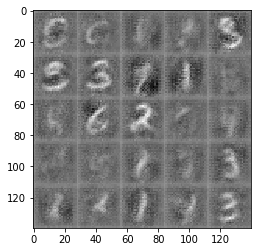

Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 0.7761


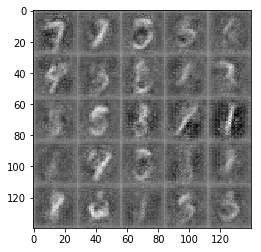

Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.6167


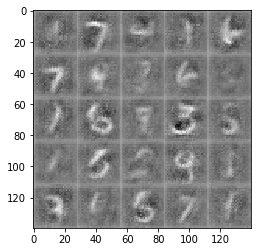

Epoch 2/2... Discriminator Loss: 1.5099... Generator Loss: 0.7790


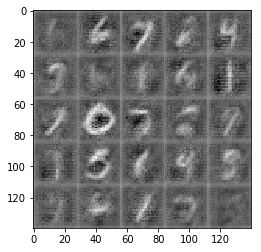

Epoch 2/2... Discriminator Loss: 1.4947... Generator Loss: 0.5193


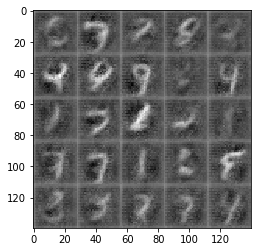

Epoch 2/2... Discriminator Loss: 1.5279... Generator Loss: 0.5782


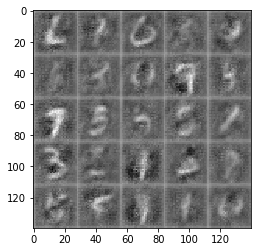

Epoch 2/2... Discriminator Loss: 1.5096... Generator Loss: 0.8769


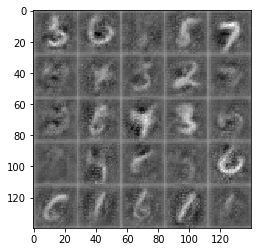

Epoch 2/2... Discriminator Loss: 1.4826... Generator Loss: 0.9089


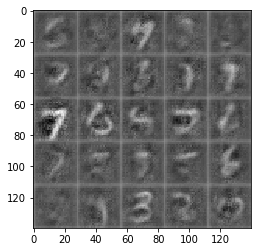

Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 1.0156


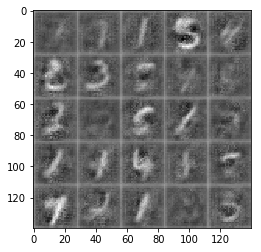

Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.9525


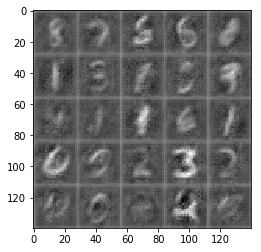

Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.7361


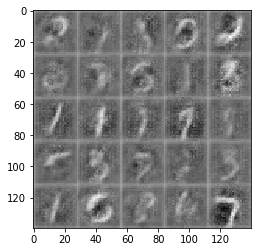

Epoch 2/2... Discriminator Loss: 1.5228... Generator Loss: 0.8044


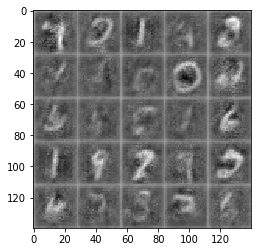

Epoch 2/2... Discriminator Loss: 1.4881... Generator Loss: 0.7214


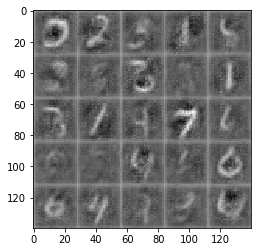

Epoch 2/2... Discriminator Loss: 1.4927... Generator Loss: 0.8588


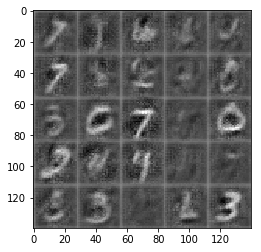

Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.5564


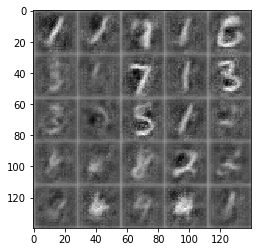

Epoch 2/2... Discriminator Loss: 1.5217... Generator Loss: 0.5378


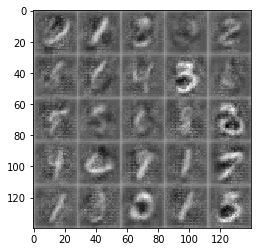

Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.7006


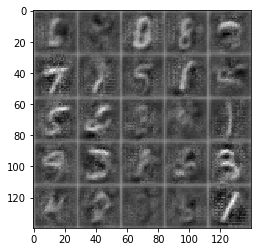

Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.9583


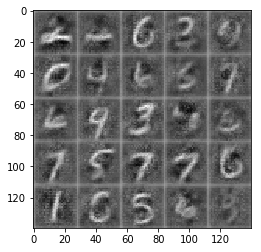

Epoch 2/2... Discriminator Loss: 1.5326... Generator Loss: 1.0783


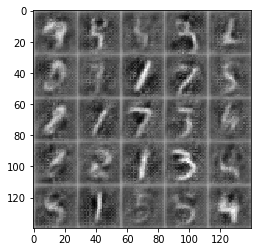

Epoch 2/2... Discriminator Loss: 1.5229... Generator Loss: 0.4547


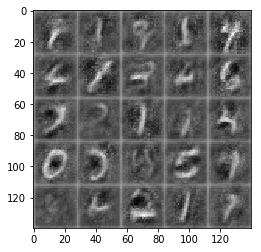

In [12]:
batch_size = 32
learning_rate = 4e-4
beta1 = 0.5
z_dim= 5*5*5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 3.4728... Generator Loss: 0.1471


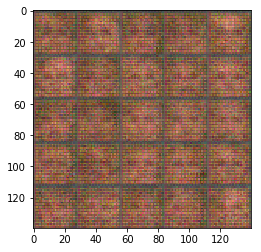

Epoch 1/5... Discriminator Loss: 3.1482... Generator Loss: 0.2513


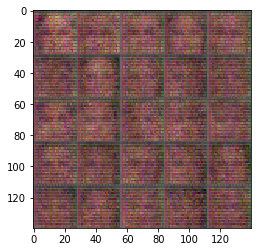

Epoch 1/5... Discriminator Loss: 2.7952... Generator Loss: 0.2990


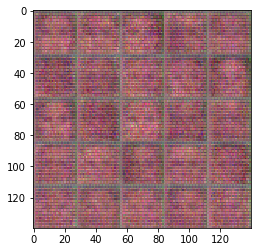

Epoch 1/5... Discriminator Loss: 2.5022... Generator Loss: 0.3562


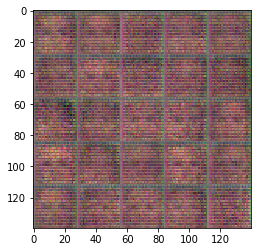

Epoch 1/5... Discriminator Loss: 2.4654... Generator Loss: 0.3840


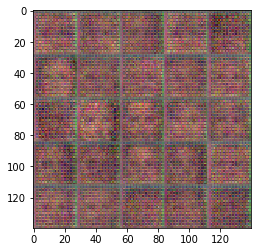

Epoch 1/5... Discriminator Loss: 2.2075... Generator Loss: 0.3993


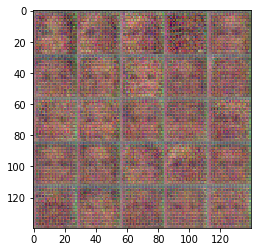

Epoch 1/5... Discriminator Loss: 2.1193... Generator Loss: 0.4628


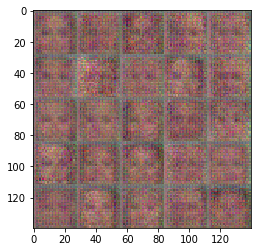

Epoch 1/5... Discriminator Loss: 2.0119... Generator Loss: 0.4815


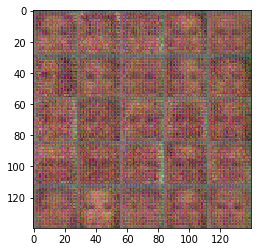

Epoch 1/5... Discriminator Loss: 2.0053... Generator Loss: 0.4902


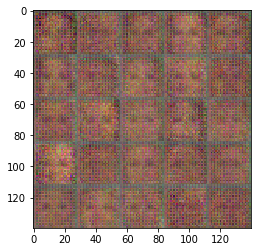

Epoch 1/5... Discriminator Loss: 2.0073... Generator Loss: 0.5104


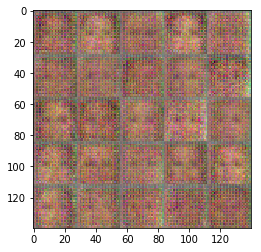

Epoch 1/5... Discriminator Loss: 1.9542... Generator Loss: 0.5263


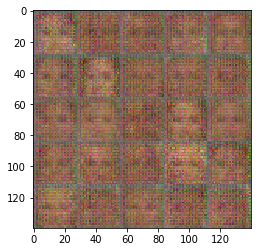

Epoch 1/5... Discriminator Loss: 1.9431... Generator Loss: 0.5129


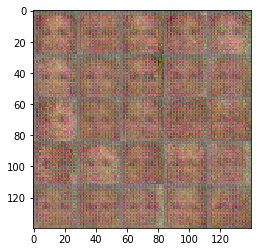

Epoch 1/5... Discriminator Loss: 1.9079... Generator Loss: 0.5396


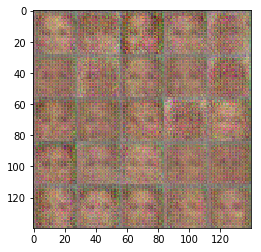

Epoch 1/5... Discriminator Loss: 1.8776... Generator Loss: 0.5415


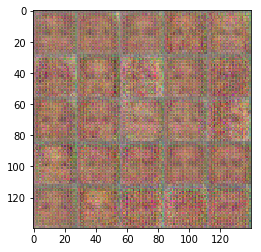

Epoch 1/5... Discriminator Loss: 1.9138... Generator Loss: 0.5166


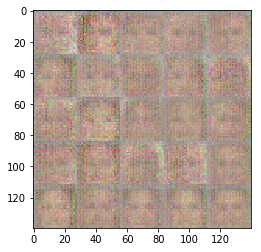

Epoch 1/5... Discriminator Loss: 1.8184... Generator Loss: 0.5592


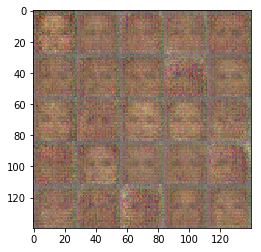

Epoch 1/5... Discriminator Loss: 1.8690... Generator Loss: 0.5479


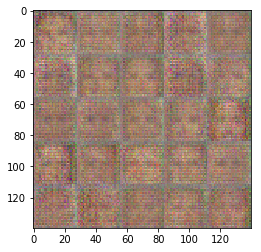

Epoch 1/5... Discriminator Loss: 1.7785... Generator Loss: 0.5742


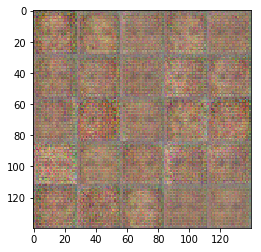

Epoch 1/5... Discriminator Loss: 1.8032... Generator Loss: 0.5718


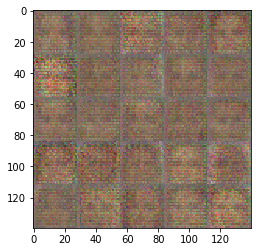

Epoch 1/5... Discriminator Loss: 1.7857... Generator Loss: 0.5844


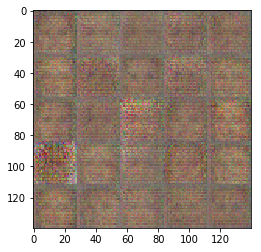

Epoch 1/5... Discriminator Loss: 1.7782... Generator Loss: 0.5920


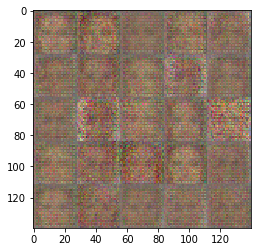

Epoch 1/5... Discriminator Loss: 1.7492... Generator Loss: 0.6044


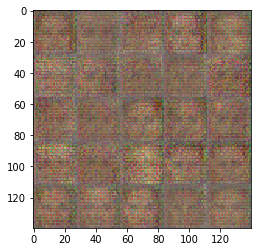

Epoch 1/5... Discriminator Loss: 1.7801... Generator Loss: 0.5904


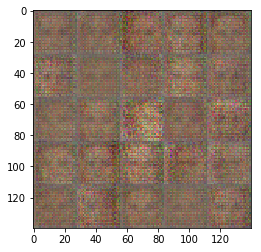

Epoch 1/5... Discriminator Loss: 1.7710... Generator Loss: 0.5643


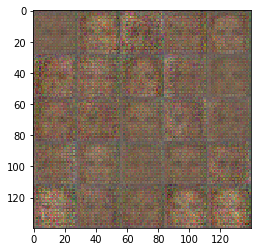

Epoch 1/5... Discriminator Loss: 1.7702... Generator Loss: 0.5881


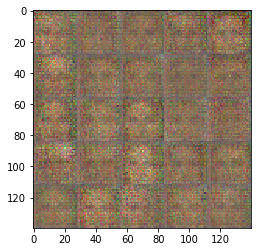

Epoch 1/5... Discriminator Loss: 1.7656... Generator Loss: 0.6154


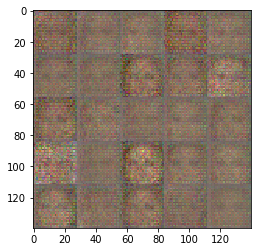

Epoch 1/5... Discriminator Loss: 1.7608... Generator Loss: 0.6079


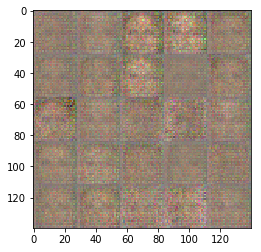

Epoch 1/5... Discriminator Loss: 1.7128... Generator Loss: 0.6180


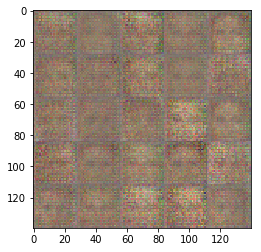

Epoch 1/5... Discriminator Loss: 1.6777... Generator Loss: 0.6159


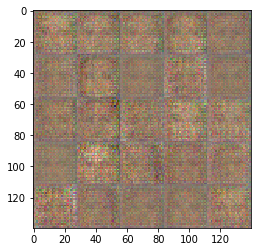

Epoch 1/5... Discriminator Loss: 1.7366... Generator Loss: 0.5998


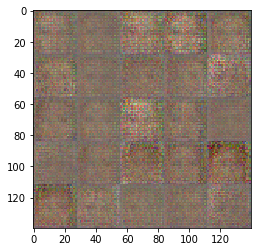

Epoch 1/5... Discriminator Loss: 1.7548... Generator Loss: 0.5945


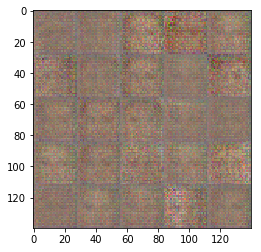

Epoch 2/5... Discriminator Loss: 1.7142... Generator Loss: 0.6206


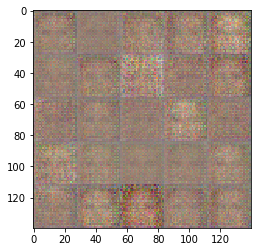

Epoch 2/5... Discriminator Loss: 1.6634... Generator Loss: 0.6524


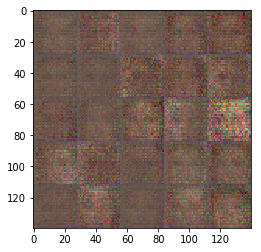

Epoch 2/5... Discriminator Loss: 1.6557... Generator Loss: 0.6320


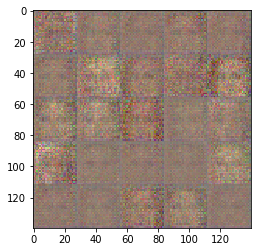

Epoch 2/5... Discriminator Loss: 1.6633... Generator Loss: 0.6436


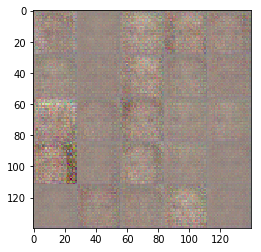

Epoch 2/5... Discriminator Loss: 1.6839... Generator Loss: 0.6391


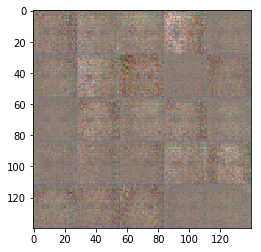

Epoch 2/5... Discriminator Loss: 1.6060... Generator Loss: 0.6344


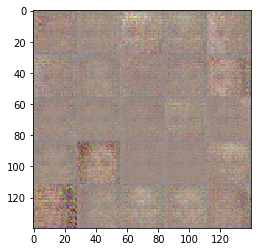

Epoch 2/5... Discriminator Loss: 1.6384... Generator Loss: 0.6516


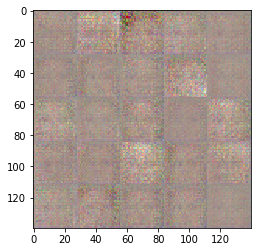

Epoch 2/5... Discriminator Loss: 1.6459... Generator Loss: 0.6377


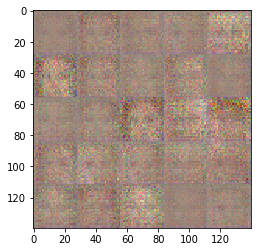

Epoch 2/5... Discriminator Loss: 1.6370... Generator Loss: 0.6400


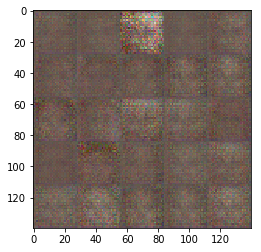

Epoch 2/5... Discriminator Loss: 1.6200... Generator Loss: 0.6908


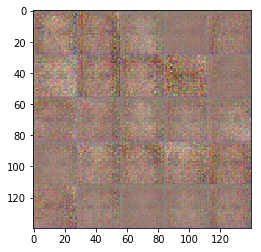

Epoch 2/5... Discriminator Loss: 1.6066... Generator Loss: 0.6859


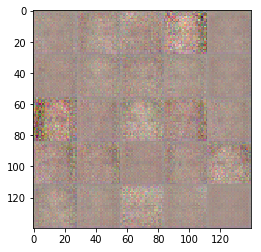

Epoch 2/5... Discriminator Loss: 1.5925... Generator Loss: 0.6626


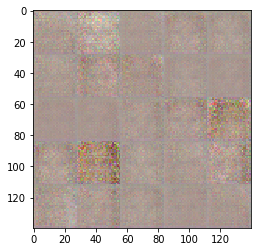

Epoch 2/5... Discriminator Loss: 1.6024... Generator Loss: 0.6739


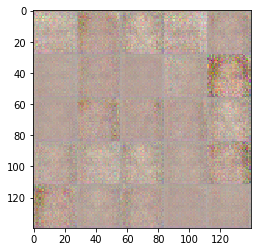

Epoch 2/5... Discriminator Loss: 1.6217... Generator Loss: 0.6510


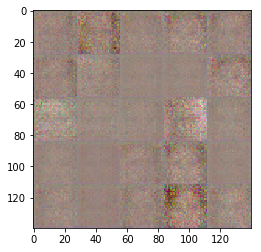

Epoch 2/5... Discriminator Loss: 1.6281... Generator Loss: 0.6641


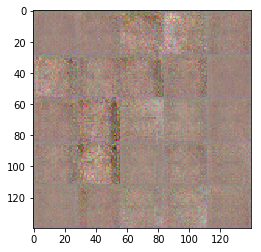

Epoch 2/5... Discriminator Loss: 1.6080... Generator Loss: 0.6529


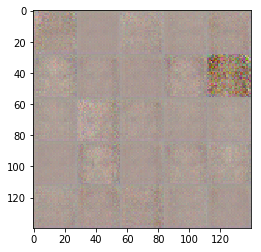

Epoch 2/5... Discriminator Loss: 1.6101... Generator Loss: 0.6731


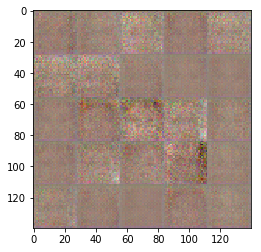

Epoch 2/5... Discriminator Loss: 1.5937... Generator Loss: 0.6723


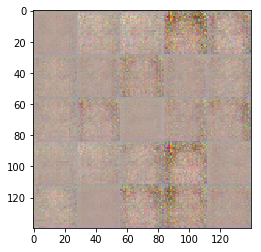

Epoch 2/5... Discriminator Loss: 1.5993... Generator Loss: 0.6815


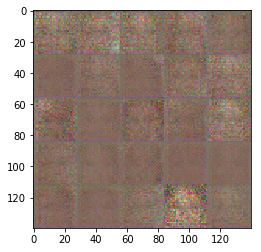

Epoch 2/5... Discriminator Loss: 1.6015... Generator Loss: 0.6733


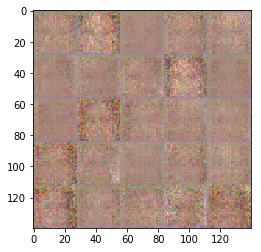

Epoch 2/5... Discriminator Loss: 1.5651... Generator Loss: 0.6945


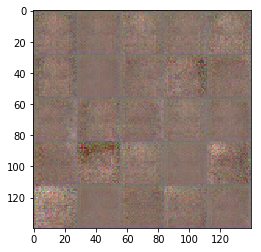

Epoch 2/5... Discriminator Loss: 1.5611... Generator Loss: 0.6869


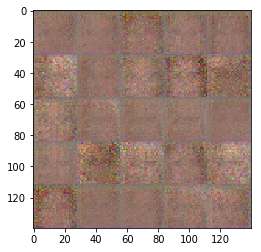

Epoch 2/5... Discriminator Loss: 1.5593... Generator Loss: 0.7172


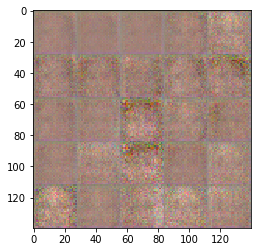

Epoch 2/5... Discriminator Loss: 1.5800... Generator Loss: 0.6865


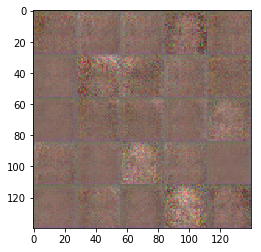

Epoch 2/5... Discriminator Loss: 1.5586... Generator Loss: 0.6621


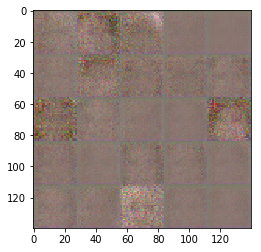

Epoch 2/5... Discriminator Loss: 1.5596... Generator Loss: 0.6953


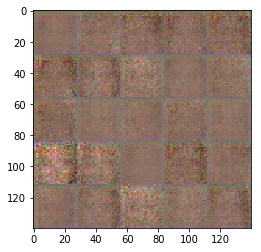

Epoch 2/5... Discriminator Loss: 1.5557... Generator Loss: 0.7075


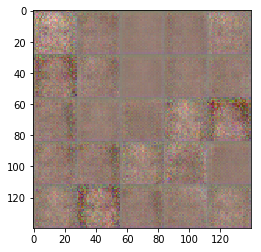

Epoch 2/5... Discriminator Loss: 1.5506... Generator Loss: 0.6957


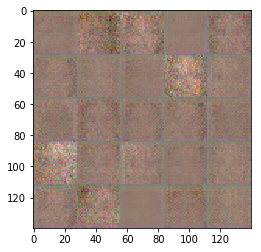

Epoch 2/5... Discriminator Loss: 1.5445... Generator Loss: 0.6943


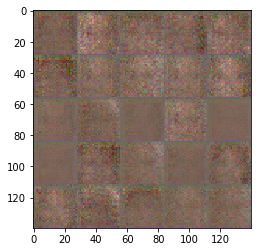

Epoch 2/5... Discriminator Loss: 1.5421... Generator Loss: 0.6966


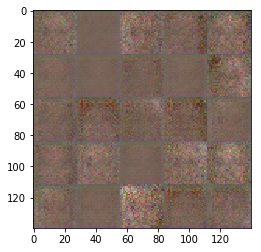

Epoch 2/5... Discriminator Loss: 1.5611... Generator Loss: 0.6945


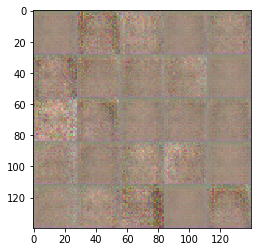

Epoch 2/5... Discriminator Loss: 1.5138... Generator Loss: 0.7306


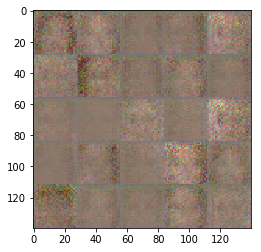

Epoch 3/5... Discriminator Loss: 1.5431... Generator Loss: 0.7250


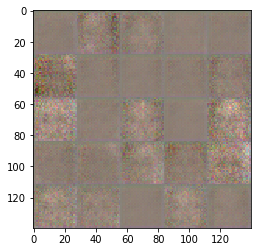

Epoch 3/5... Discriminator Loss: 1.5349... Generator Loss: 0.7172


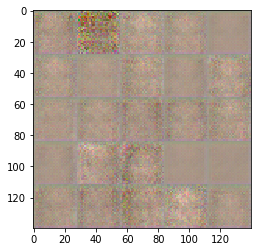

Epoch 3/5... Discriminator Loss: 1.5043... Generator Loss: 0.6786


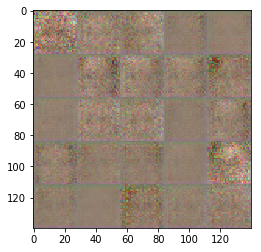

Epoch 3/5... Discriminator Loss: 1.5360... Generator Loss: 0.7034


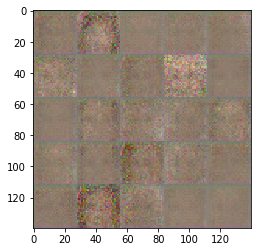

Epoch 3/5... Discriminator Loss: 1.5225... Generator Loss: 0.6815


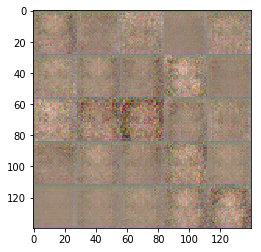

Epoch 3/5... Discriminator Loss: 1.5434... Generator Loss: 0.7080


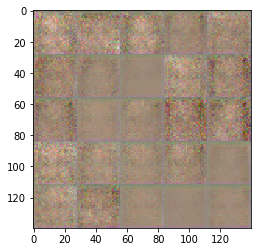

Epoch 3/5... Discriminator Loss: 1.5246... Generator Loss: 0.7242


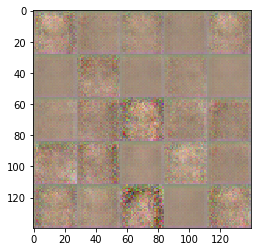

Epoch 3/5... Discriminator Loss: 1.5327... Generator Loss: 0.7059


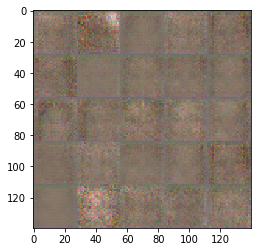

Epoch 3/5... Discriminator Loss: 1.5267... Generator Loss: 0.7153


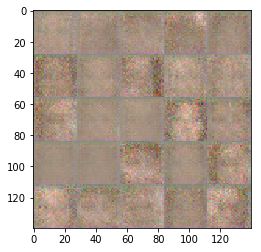

Epoch 3/5... Discriminator Loss: 1.5286... Generator Loss: 0.7086


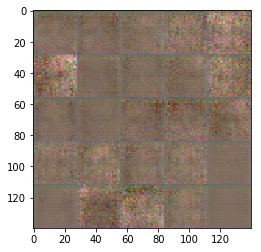

Epoch 3/5... Discriminator Loss: 1.5036... Generator Loss: 0.6967


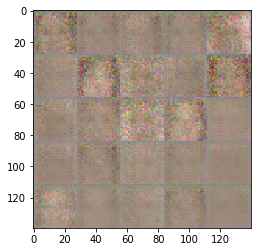

Epoch 3/5... Discriminator Loss: 1.5284... Generator Loss: 0.7098


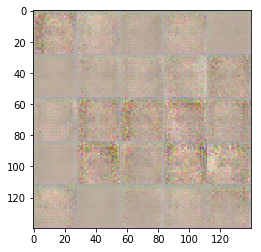

Epoch 3/5... Discriminator Loss: 1.5120... Generator Loss: 0.6971


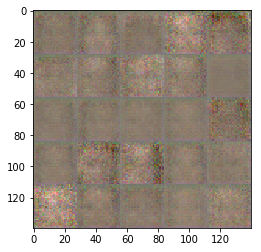

In [ ]:
batch_size = 64
z_dim = 5*5*5
learning_rate = 2e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.